## Importowanie bibliotek

In [161]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.src.layers import Dropout
from keras.src.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Załadowanie zmiennych

In [162]:
with open('data_dump/dataAnalysisVars.pkl', 'rb') as f:
    df = pickle.load(f)

    df_0 = pickle.load(f)
    df_mean = pickle.load(f)
    df_interpolate = pickle.load(f)

    normalized_std_0 = pickle.load(f)
    scaler_std_0 = pickle.load(f)

    normalized_std_mean = pickle.load(f)
    scaler_std_mean = pickle.load(f)

    normalized_std_interpolate = pickle.load(f)
    scaler_std_interpolate = pickle.load(f)

    normalized_minmax_0 = pickle.load(f)
    scaler_minmax_0 = pickle.load(f)

    normalized_minmax_mean = pickle.load(f)
    scaler_minmax_mean = pickle.load(f)

    normalized_minmax_interpolate = pickle.load(f)
    scaler_minmax_interpolate = pickle.load(f)

## Funkcje do podziału zbioru danych

In [163]:
def split_df_train_test(data, test_size, seed):
    np.random.seed(seed)

    unique_labels = data['Potability'].unique()
    label_counts = data['Potability'].value_counts()

    test_indices = []

    for label in unique_labels:
        num_label_samples = label_counts[label]
        num_test_samples = int(test_size * num_label_samples)
        label_indices = data.index[data['Potability'] == label].tolist()
        label_test_indices = np.random.choice(label_indices, size=num_test_samples, replace=False)
        test_indices.extend(label_test_indices)

    train_indices = np.setdiff1d(data.index, test_indices)

    train_set = data.loc[train_indices]
    test_set = data.loc[test_indices]

    return train_set, test_set

def split_df_train_val_test(data, val_size, test_size, seed):
    np.random.seed(seed)

    unique_labels = data['Potability'].unique()
    label_counts = data['Potability'].value_counts()

    val_size = int(val_size * len(data))
    test_size = int(test_size * len(data))

    val_indices = []
    test_indices = []

    for label in unique_labels:
        num_label_samples = label_counts[label]

        num_val_samples = int(val_size * (num_label_samples / len(data)))
        num_test_samples = int(test_size * (num_label_samples / len(data)))

        label_indices = data.index[data['Potability'] == label].tolist()

        label_val_indices = np.random.choice(label_indices, size=num_val_samples, replace=False)
        val_indices.extend(label_val_indices)

        remaining_indices = np.setdiff1d(label_indices, label_val_indices)
        label_test_indices = np.random.choice(remaining_indices, size=num_test_samples, replace=False)
        test_indices.extend(label_test_indices)

    train_indices = np.setdiff1d(data.index, np.concatenate((val_indices, test_indices)))

    train_set = data.loc[train_indices]
    val_set = data.loc[val_indices]
    test_set = data.loc[test_indices]

    return train_set, val_set, test_set

## SVM - Scikit-Learn

In [164]:
class SVMClassifierWrapper:

    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = SVC(random_state=42)

    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'C': [0.1, 1, 5, 10],
                'probability': [True, False],
            }

        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=8, cv=5, random_state=645, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, test_pred)
        print('-' * 18 + ' SVM ' + '-' * 18)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('-' * 41)
        return test_acc


## Random Forest - Scikit-Learn

In [165]:
class RandomForestClassifierWrapper:

    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = RandomForestClassifier(random_state=42)

    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100, 150],
                'criterion': ['gini', 'entropy'],
                'bootstrap': [True, False]
            }

        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=12, cv=5, random_state=42, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, test_pred)
        print('-' * 13 + ' Random Forest ' + '-' * 13)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('-' * 41)
        return test_acc


### Gradient Boosting

In [166]:
class GBClassifierWrapper:

    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = GradientBoostingClassifier(random_state=42)

    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100, 150]
            }

        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=3, cv=5, random_state=645, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, test_pred)
        print('-' * 11 + ' Gradient Boosting ' + '-' * 11)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('-' * 41)
        return test_acc

### XGBoost

In [167]:
class XGBClassifierWrapper:

    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = XGBClassifier(random_state=42, tree_method = "hist", device = "cuda")

    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100],
                'max_depth': [3, 5, 10],
            }

        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=6, cv=5, random_state=678, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, test_pred)
        print('-' * 16 + ' XGBoost ' + '-' * 16)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('-' * 41)
        return test_acc

## MLP - Keras

In [168]:
class MLPClassifierWrapper:

    def __init__(self, train_set, val_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.val_set = val_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.val_label = val_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = Sequential()

        self.model.add(Input(shape=(9,)))
        self.model.add(Dense(40, activation='leaky_relu'))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(30, activation='leaky_relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(20, activation='leaky_relu'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

    def train_model(self):
        self.history = self.model.fit(self.train_set, self.train_label, epochs=150, batch_size=64, validation_data=(self.val_set, self.val_label))

    def evaluate_model(self):
        test_loss, test_acc = self.model.evaluate(self.test_set, self.test_label)
        print('-' * 18 + ' MLP ' + '-' * 18)
        print('Test accuracy:', test_acc)
        print('Test loss:', test_loss)
        print('-' * 41)
        return test_acc

    def plot_results(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()


## Trenowanie modeli

### Split danych

In [169]:
# Std zeros
train_std_0, test_std_0 = split_df_train_test(normalized_std_0, 0.2, 123)
train_std_mlp_0, val_std_mlp_0, test_std_mlp_0 = split_df_train_val_test(normalized_minmax_0, 0.1, 0.1, 111)

# Std mean
train_std_mean, test_std_mean = split_df_train_test(normalized_std_mean, 0.2, 123)
train_std_mlp_mean, val_std_mlp_mean, test_std_mlp_mean = split_df_train_val_test(normalized_std_mean, 0.1, 0.1, 111)

# Std interpolate
train_std_interpolate, test_std_interpolate = split_df_train_test(normalized_std_interpolate, 0.2, 123)
train_std_mlp_interpolate, val_std_mlp_interpolate, test_std_mlp_interpolate = split_df_train_val_test(normalized_std_interpolate, 0.1, 0.1, 111)

# Minmax zeros
train_minmax_0, test_minmax_0 = split_df_train_test(normalized_minmax_0, 0.2, 123)
train_minmax_mlp_0, val_minmax_mlp_0, test_minmax_mlp_0 = split_df_train_val_test(normalized_minmax_0, 0.1, 0.1, 111)

# Minmax mean
train_minmax_mean, test_minmax_mean = split_df_train_test(normalized_minmax_mean, 0.2, 123)
train_minmax_mlp_mean, val_minmax_mlp_mean, test_minmax_mlp_mean = split_df_train_val_test(normalized_minmax_mean, 0.1, 0.1, 111)

# Minmax interpolate
train_minmax_interpolate, test_minmax_interpolate = split_df_train_test(normalized_minmax_interpolate, 0.2, 123)
train_minmax_mlp_interpolate, val_minmax_mlp_interpolate, test_minmax_mlp_interpolate = split_df_train_val_test(normalized_minmax_interpolate, 0.1, 0.1, 111)

### Podział klas po splicie - test/train

In [170]:
train_class_counts = train_minmax_interpolate['Potability'].value_counts(normalize=True) * 100
test_class_counts = test_minmax_interpolate['Potability'].value_counts(normalize=True) * 100

print("Train set:")
print(train_class_counts)
print("\nTest set:")
print(test_class_counts)

Train set:
Potability
0    60.983982
1    39.016018
Name: proportion, dtype: float64

Test set:
Potability
0    61.009174
1    38.990826
Name: proportion, dtype: float64


### Podział klas po splicie - test/val/train

In [171]:
train_mlp_class_counts = train_minmax_mlp_interpolate['Potability'].value_counts(normalize=True) * 100
val_mlp_class_counts = val_minmax_mlp_interpolate['Potability'].value_counts(normalize=True) * 100
test_mlp_class_counts = test_minmax_mlp_interpolate['Potability'].value_counts(normalize=True) * 100

print("Train MLP set:")
print(train_mlp_class_counts)
print("\nValidation MLP set:")
print(val_mlp_class_counts)
print("\nTest MLP set:")
print(test_mlp_class_counts)

Train MLP set:
Potability
0    60.97561
1    39.02439
Name: proportion, dtype: float64

Validation MLP set:
Potability
0    61.042945
1    38.957055
Name: proportion, dtype: float64

Test MLP set:
Potability
0    61.042945
1    38.957055
Name: proportion, dtype: float64


### Trenowanie SVM

In [172]:
# Std zeros
modelSVM_std_0 = SVMClassifierWrapper(train_std_0, test_std_0)
modelSVM_std_0.train_model()
accuracy_SVM_std_0 = modelSVM_std_0.evaluate_model()

# Std mean
modelSVM_std_mean = SVMClassifierWrapper(train_std_mean, test_std_mean)
modelSVM_std_mean.train_model()
accuracy_SVM_std_mean = modelSVM_std_mean.evaluate_model()

# Std interpolate
modelSVM_std_interpolate = SVMClassifierWrapper(train_std_interpolate, test_std_interpolate)
modelSVM_std_interpolate.train_model()
accuracy_SVM_std_interpolate = modelSVM_std_interpolate.evaluate_model()

# Minmax zeros
modelSVM_minmax_0 = SVMClassifierWrapper(train_minmax_0, test_minmax_0)
modelSVM_minmax_0.train_model()
accuracy_SVM_minmax_0 = modelSVM_minmax_0.evaluate_model()

# Minmax mean
modelSVM_minmax_mean = SVMClassifierWrapper(train_minmax_mean, test_minmax_mean)
modelSVM_minmax_mean.train_model()
accuracy_SVM_minmax_mean = modelSVM_minmax_mean.evaluate_model()

# Minmax interpolate
modelSVM_minmax_interpolate = SVMClassifierWrapper(train_minmax_interpolate, test_minmax_interpolate)
modelSVM_minmax_interpolate.train_model()
accuracy_SVM_minmax_interpolate = modelSVM_minmax_interpolate.evaluate_model()

------------------ SVM ------------------
C: 5
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: True
random_state: 42
shrinking: True
tol: 0.001
verbose: False
-----------------------------------------
Test accuracy: 0.6207951070336392
-----------------------------------------
------------------ SVM ------------------
C: 1
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: True
random_state: 42
shrinking: True
tol: 0.001
verbose: False
-----------------------------------------
Test accuracy: 0.672782874617737
-----------------------------------------
------------------ SVM ------------------
C: 1
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: True
random_state: 42
shrinking: T

### Trenowanie Random Forest

In [173]:
# Std zeros
modelRF_std_0 = RandomForestClassifierWrapper(train_std_0, test_std_0)
modelRF_std_0.train_model()
accuracy_RF_std_0 = modelRF_std_0.evaluate_model()

# Std mean
modelRF_std_mean = RandomForestClassifierWrapper(train_std_mean, test_std_mean)
modelRF_std_mean.train_model()
accuracy_RF_std_mean = modelRF_std_mean.evaluate_model()

# Std interpolate
modelRF_std_interpolate = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate)
modelRF_std_interpolate.train_model()
accuracy_RF_std_interpolate = modelRF_std_interpolate.evaluate_model()

# Minmax zeros
modelRF_minmax_0 = RandomForestClassifierWrapper(train_minmax_0, test_minmax_0)
modelRF_minmax_0.train_model()
accuracy_RF_minmax_0 = modelRF_minmax_0.evaluate_model()

# Minmax mean
modelRF_minmax_mean = RandomForestClassifierWrapper(train_minmax_mean, test_minmax_mean)
modelRF_minmax_mean.train_model()
accuracy_RF_minmax_mean = modelRF_minmax_mean.evaluate_model()

# Minmax interpolate
modelRF_minmax_interpolate = RandomForestClassifierWrapper(train_minmax_interpolate, test_minmax_interpolate)
modelRF_minmax_interpolate.train_model()
accuracy_RF_minmax_interpolate = modelRF_minmax_interpolate.evaluate_model()

------------- Random Forest -------------
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
-----------------------------------------
Test accuracy: 0.6406727828746177
-----------------------------------------
------------- Random Forest -------------
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 150
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
-----------------------------------------
Test accuracy: 0.6697247706422018
-----------------------------------------
------------- Ra

### Trenowanie Gradient Boosting

In [174]:
# Std zeros
modelGB_std_0 = GBClassifierWrapper(train_std_0, test_std_0)
modelGB_std_0.train_model()
accuracy_GB_std_0 = modelGB_std_0.evaluate_model()

# Std mean
modelGB_std_mean = GBClassifierWrapper(train_std_mean, test_std_mean)
modelGB_std_mean.train_model()
accuracy_GB_std_mean = modelGB_std_mean.evaluate_model()

# Std interpolate
modelGB_std_interpolate = GBClassifierWrapper(train_std_interpolate, test_std_interpolate)
modelGB_std_interpolate.train_model()
accuracy_GB_std_interpolate = modelGB_std_interpolate.evaluate_model()

# Minmax zeros
modelGB_minmax_0 = GBClassifierWrapper(train_minmax_0, test_minmax_0)
modelGB_minmax_0.train_model()
accuracy_GB_minmax_0 = modelGB_minmax_0.evaluate_model()

# Minmax mean
modelGB_minmax_mean = GBClassifierWrapper(train_minmax_mean, test_minmax_mean)
modelGB_minmax_mean.train_model()
accuracy_GB_minmax_mean = modelGB_minmax_mean.evaluate_model()

# Minmax interpolate
modelGB_minmax_interpolate = GBClassifierWrapper(train_minmax_interpolate, test_minmax_interpolate)
modelGB_minmax_interpolate.train_model()
accuracy_GB_minmax_interpolate = modelGB_minmax_interpolate.evaluate_model()

----------- Gradient Boosting -----------
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.1
loss: log_loss
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 50
n_iter_no_change: None
random_state: 42
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False
-----------------------------------------
Test accuracy: 0.6207951070336392
-----------------------------------------
----------- Gradient Boosting -----------
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.1
loss: log_loss
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 50
n_iter_no_change: None
random_state: 42
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False
-----------------------------------------
Test accur

### Trenowanie XGBoost

In [175]:
# Std zeros
modelXGB_std_0 = XGBClassifierWrapper(train_std_0, test_std_0)
modelXGB_std_0.train_model()
accuracy_XGB_std_0 = modelXGB_std_0.evaluate_model()

# Std mean
modelXGB_std_mean = XGBClassifierWrapper(train_std_mean, test_std_mean)
modelXGB_std_mean.train_model()
accuracy_XGB_std_mean = modelXGB_std_mean.evaluate_model()

# Std interpolate
modelXGB_std_interpolate = XGBClassifierWrapper(train_std_interpolate, test_std_interpolate)
modelXGB_std_interpolate.train_model()
accuracy_XGB_std_interpolate = modelXGB_std_interpolate.evaluate_model()

# Minmax zeros
modelXGB_minmax_0 = XGBClassifierWrapper(train_minmax_0, test_minmax_0)
modelXGB_minmax_0.train_model()
accuracy_XGB_minmax_0 = modelXGB_minmax_0.evaluate_model()

# Minmax mean
modelXGB_minmax_mean = XGBClassifierWrapper(train_minmax_mean, test_minmax_mean)
modelXGB_minmax_mean.train_model()
accuracy_XGB_minmax_mean = modelXGB_minmax_mean.evaluate_model()

# Minmax interpolate
modelXGB_minmax_interpolate = XGBClassifierWrapper(train_minmax_interpolate, test_minmax_interpolate)
modelXGB_minmax_interpolate.train_model()
accuracy_XGB_minmax_interpolate = modelXGB_minmax_interpolate.evaluate_model()

---------------- XGBoost ----------------
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: cuda
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 3
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 50
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: hist
validate_parameters: None
verbosity: None
-----------------------------------------
Test accuracy: 0.6330275229357798
-----------------------------------------
---------------- XGBoost ----------------
objective: binary:logisti

### Trenowanie MLP

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4212 - loss: 0.7930 - val_accuracy: 0.5583 - val_loss: 0.7033
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.5197 - loss: 0.7106 - val_accuracy: 0.5613 - val_loss: 0.6800
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.5484 - loss: 0.6909 - val_accuracy: 0.5982 - val_loss: 0.6754
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.5817 - loss: 0.6795 - val_accuracy: 0.6074 - val_loss: 0.6748
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.5973 - loss: 0.6800 - val_accuracy: 0.6074 - val_loss: 0.6744
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.5811 - loss: 0.6845 - val_accuracy: 0.6074 - val_loss: 0.6743
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.5741 - loss: 0.6875 - val_accuracy: 0.6104 - val_loss: 0.6737
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.6053 - loss: 0.6690 - val_accur

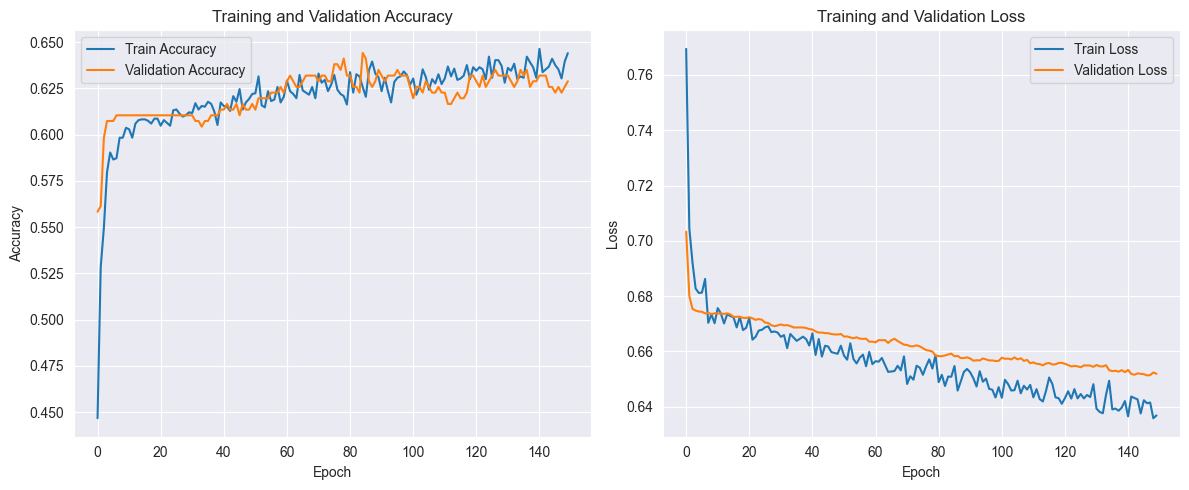

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5877 - loss: 0.7126 - val_accuracy: 0.5951 - val_loss: 0.6880
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5882 - loss: 0.6968 - val_accuracy: 0.5890 - val_loss: 0.6836
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5997 - loss: 0.6884 - val_accuracy: 0.5982 - val_loss: 0.6808
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5773 - loss: 0.6934 - val_accuracy: 0.6104 - val_loss: 0.6790
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.5777 - loss: 0.6826 - val_accuracy: 0.6135 - val_loss: 0.6778
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.6065 - loss: 0.6799 - val_accuracy: 0.6166 - val_loss: 0.6771
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.6010 - loss: 0.6773 - val_accuracy: 0.6135 - val_loss: 0.6763
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.6090 - loss: 0.6734 - val_accuracy: 0.

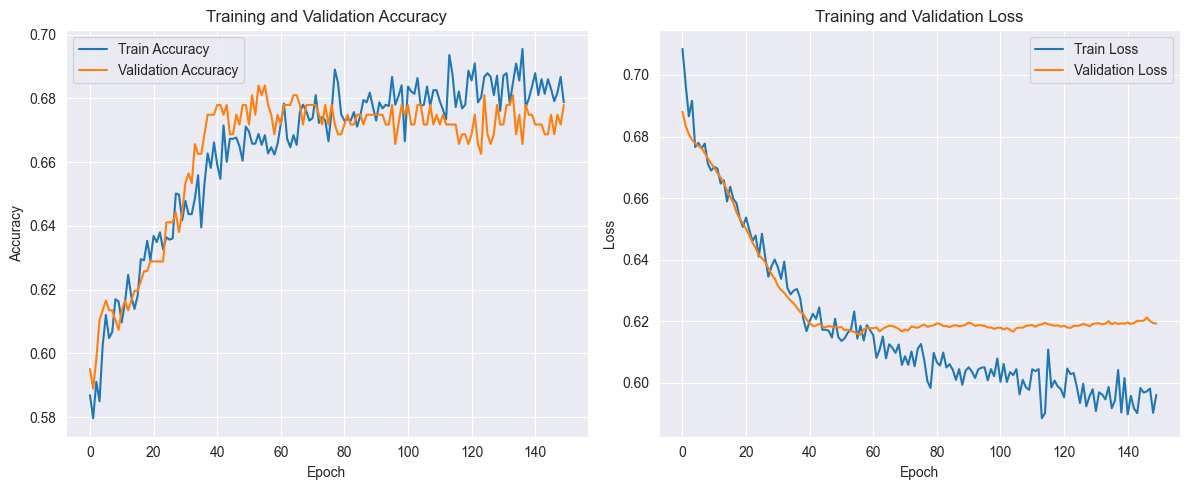

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5725 - loss: 0.6852 - val_accuracy: 0.5706 - val_loss: 0.6883
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.5810 - loss: 0.6755 - val_accuracy: 0.5859 - val_loss: 0.6843
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.6149 - loss: 0.6743 - val_accuracy: 0.5859 - val_loss: 0.6815
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.5949 - loss: 0.6786 - val_accuracy: 0.5920 - val_loss: 0.6793
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.6053 - loss: 0.6743 - val_accuracy: 0.5982 - val_loss: 0.6771
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.5983 - loss: 0.6746 - val_accuracy: 0.5920 - val_loss: 0.6746
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.6220 - loss: 0.6620 - val_accuracy: 0.5982 - val_loss: 0.6728
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.6154 - loss: 0.6666 - val_accur

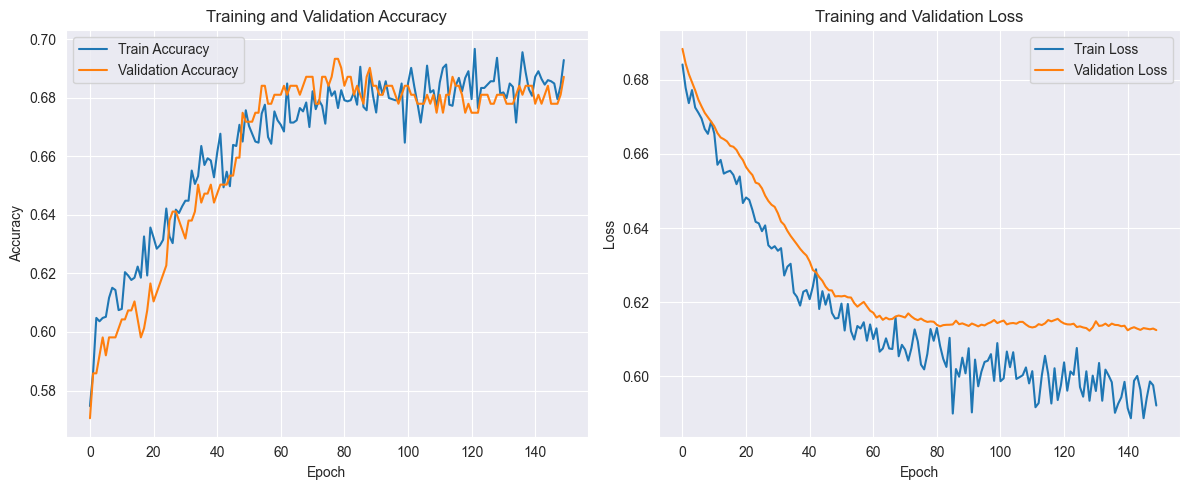

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4777 - loss: 0.7396 - val_accuracy: 0.5675 - val_loss: 0.6755
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5249 - loss: 0.7015 - val_accuracy: 0.6319 - val_loss: 0.6690
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.5643 - loss: 0.6874 - val_accuracy: 0.6196 - val_loss: 0.6688
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.6048 - loss: 0.6707 - val_accuracy: 0.6166 - val_loss: 0.6690
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.5884 - loss: 0.6752 - val_accuracy: 0.6135 - val_loss: 0.6686
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.5946 - loss: 0.6828 - val_accuracy: 0.6135 - val_loss: 0.6698
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.6010 - loss: 0.6738 - val_accuracy: 0.6104 - val_loss: 0.6696
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.6056 - loss: 0.6748 - val_accuracy

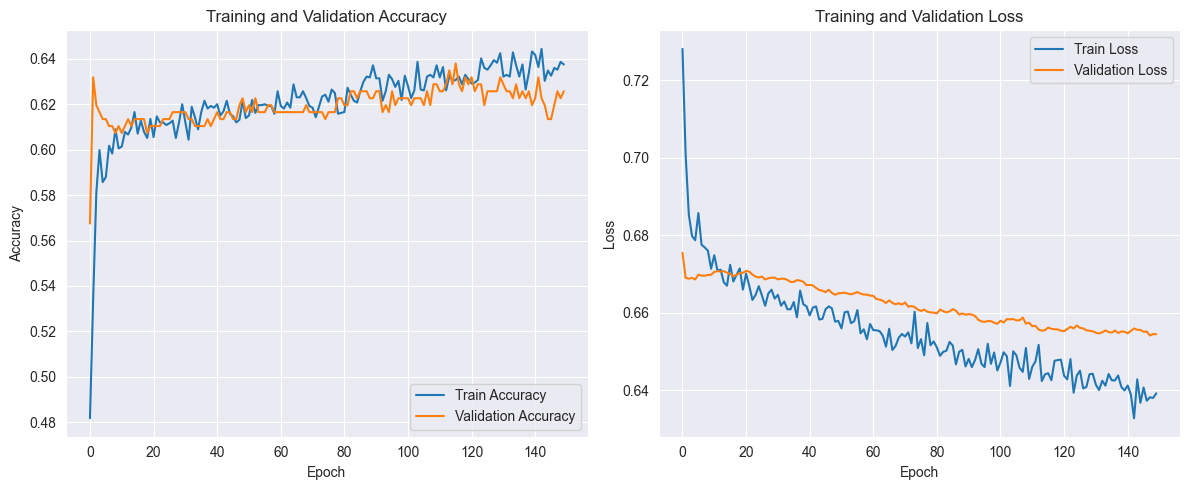

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4024 - loss: 0.7715 - val_accuracy: 0.4969 - val_loss: 0.6973
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.4772 - loss: 0.7143 - val_accuracy: 0.6043 - val_loss: 0.6823
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.5139 - loss: 0.6968 - val_accuracy: 0.6319 - val_loss: 0.6761
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.5801 - loss: 0.6822 - val_accuracy: 0.6196 - val_loss: 0.6732
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.5672 - loss: 0.6849 - val_accuracy: 0.6166 - val_loss: 0.6719
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.5802 - loss: 0.6845 - val_accuracy: 0.6104 - val_loss: 0.6713
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.6174 - loss: 0.6674 - val_accuracy: 0.6135 - val_loss: 0.6702
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.6204 - loss: 0.6709 - val_accur

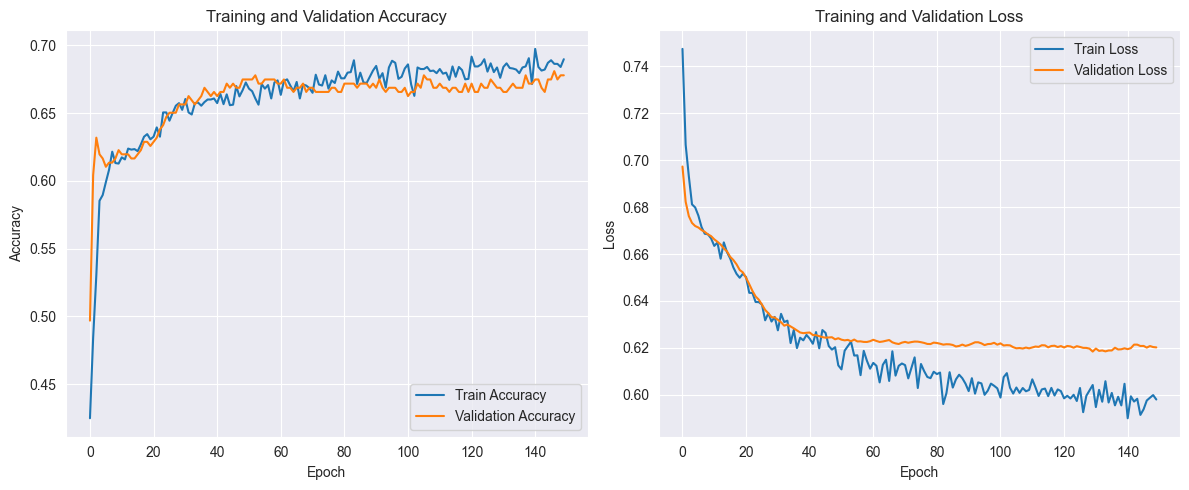

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5876 - loss: 0.6807 - val_accuracy: 0.5798 - val_loss: 0.6865
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.5944 - loss: 0.6803 - val_accuracy: 0.6012 - val_loss: 0.6825
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.5765 - loss: 0.6844 - val_accuracy: 0.6043 - val_loss: 0.6794
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.6067 - loss: 0.6686 - val_accuracy: 0.6043 - val_loss: 0.6766
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.6237 - loss: 0.6621 - val_accuracy: 0.6074 - val_loss: 0.6752
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.5895 - loss: 0.6730 - val_accuracy: 0.6104 - val_loss: 0.6735
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.5934 - loss: 0.6779 - val_accuracy: 0.6196 - val_loss: 0.6711
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.6191 - loss: 0.6616 - val_accura

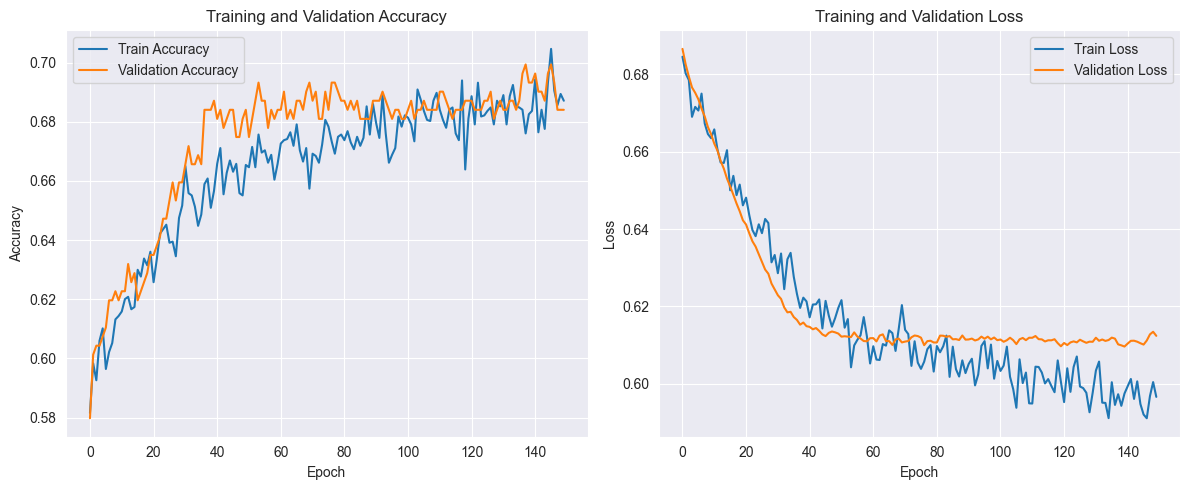

In [176]:
# Std zeros
modelMLP_std_0 = MLPClassifierWrapper(train_std_mlp_0, val_std_mlp_0, test_std_mlp_0)
modelMLP_std_0.train_model()
accuracy_MLP_std_0 = modelMLP_std_0.evaluate_model()
modelMLP_std_0.plot_results()

# Std mean
modelMLP_std_mean = MLPClassifierWrapper(train_std_mlp_mean, val_std_mlp_mean, test_std_mlp_mean)
modelMLP_std_mean.train_model()
accuracy_MLP_std_mean = modelMLP_std_mean.evaluate_model()
modelMLP_std_mean.plot_results()

# Std interpolate
modelMLP_std_interpolate = MLPClassifierWrapper(train_std_mlp_interpolate, val_std_mlp_interpolate, test_std_mlp_interpolate)
modelMLP_std_interpolate.train_model()
accuracy_MLP_std_interpolate = modelMLP_std_interpolate.evaluate_model()
modelMLP_std_interpolate.plot_results()

# Minmax zeros
modelMLP_minmax_0 = MLPClassifierWrapper(train_minmax_mlp_0, val_minmax_mlp_0, test_minmax_mlp_0)
modelMLP_minmax_0.train_model()
accuracy_MLP_minmax_0 = modelMLP_minmax_0.evaluate_model()
modelMLP_minmax_0.plot_results()

# Minmax mean
modelMLP_minmax_mean = MLPClassifierWrapper(train_minmax_mlp_mean, val_minmax_mlp_mean, test_minmax_mlp_mean)
modelMLP_minmax_mean.train_model()
accuracy_MLP_minmax_mean = modelMLP_minmax_mean.evaluate_model()
modelMLP_minmax_mean.plot_results()

# Minmax interpolate
modelMLP_minmax_interpolate = MLPClassifierWrapper(train_minmax_mlp_interpolate, val_minmax_mlp_interpolate, test_minmax_mlp_interpolate)
modelMLP_minmax_interpolate.train_model()
accuracy_MLP_minmax_interpolate = modelMLP_minmax_interpolate.evaluate_model()
modelMLP_minmax_interpolate.plot_results()

## Przedstawienie wyników

In [177]:
results_list = [
    ["SVM", accuracy_SVM_std_0, "Std", "Zeros"],
    ["SVM", accuracy_SVM_std_mean, "Std", "Mean"],
    ["SVM", accuracy_SVM_std_interpolate, "Std", "Interpolate"],
    ["SVM", accuracy_SVM_minmax_0, "Minmax", "Zeros"],
    ["SVM", accuracy_SVM_minmax_mean, "Minmax", "Mean"],
    ["SVM", accuracy_SVM_minmax_interpolate, "Minmax", "Interpolate"],
    ["Random Forest", accuracy_RF_std_0, "Std", "Zeros"],
    ["Random Forest", accuracy_RF_std_mean, "Std", "Mean"],
    ["Random Forest", accuracy_RF_std_interpolate, "Std", "Interpolate"],
    ["Random Forest", accuracy_RF_minmax_0, "Minmax", "Zeros"],
    ["Random Forest", accuracy_RF_minmax_mean, "Minmax", "Mean"],
    ["Random Forest", accuracy_RF_minmax_interpolate, "Minmax", "Interpolate"],
    ["Gradient Boosting", accuracy_GB_std_0, "Std", "Zeros"],
    ["Gradient Boosting", accuracy_GB_std_mean, "Std", "Mean"],
    ["Gradient Boosting", accuracy_GB_std_interpolate, "Std", "Interpolate"],
    ["Gradient Boosting", accuracy_GB_minmax_0, "Minmax", "Zeros"],
    ["Gradient Boosting", accuracy_GB_minmax_mean, "Minmax", "Mean"],
    ["Gradient Boosting", accuracy_GB_minmax_interpolate, "Minmax", "Interpolate"],
    ["XGBoost", accuracy_XGB_std_0, "Std", "Zeros"],
    ["XGBoost", accuracy_XGB_std_mean, "Std", "Mean"],
    ["XGBoost", accuracy_XGB_std_interpolate, "Std", "Interpolate"],
    ["XGBoost", accuracy_XGB_minmax_0, "Minmax", "Zeros"],
    ["XGBoost", accuracy_XGB_minmax_mean, "Minmax", "Mean"],
    ["XGBoost", accuracy_XGB_minmax_interpolate, "Minmax", "Interpolate"],
    ["MLP", accuracy_MLP_std_0, "Std", "Zeros"],
    ["MLP", accuracy_MLP_std_mean, "Std", "Mean"],
    ["MLP", accuracy_MLP_std_interpolate, "Std", "Interpolate"],
    ["MLP", accuracy_MLP_minmax_0, "Minmax", "Zeros"],
    ["MLP", accuracy_MLP_minmax_mean, "Minmax", "Mean"],
    ["MLP", accuracy_MLP_minmax_interpolate, "Minmax", "Interpolate"],
]

headers = ["Model", "Accuracy", "Normalization", "Missing Data"]

results_df = pd.DataFrame(results_list, columns=headers)

results_df

,Model,Accuracy,Normalization,Missing Data
0,SVM,0.620795,Std,Zeros
1,SVM,0.672783,Std,Mean
2,SVM,0.686544,Std,Interpolate
3,SVM,0.620795,Minmax,Zeros
4,SVM,0.672783,Minmax,Mean
5,SVM,0.686544,Minmax,Interpolate
6,Random Forest,0.640673,Std,Zeros
7,Random Forest,0.669725,Std,Mean
8,Random Forest,0.669725,Std,Interpolate
9,Random Forest,0.640673,Minmax,Zeros
